<a href="https://colab.research.google.com/github/ArthurYama/cognitive_AI_coursework/blob/main/Cog_AI_coursework_ContDec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Install neurogym to use cognitive tasks
! git clone https://github.com/neurogym/neurogym.git
%cd neurogym/
! pip install -e .

Cloning into 'neurogym'...
remote: Enumerating objects: 11100, done.
remote: Counting objects: 100% (1002/1002), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 11100 (delta 928), reused 896 (delta 896), pack-reused 10098 (from 1)
Receiving objects: 100% (11100/11100), 8.17 MiB | 8.54 MiB/s, done.
Resolving deltas: 100% (8333/8333), done.
/content/neurogym
Obtaining file:///content/neurogym
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.4/696.4 kB 12.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.24.1-py3-none-any.whl size=793127 sha256=f5b7b0cdc3a87030b9cb7bf2879b01cb33f865a6288fb4cec023c4ebe2551688
  Stored in directory: /root/.cache/pip/wheels/c4/fb/19/388995b88cb551717a8dff40c889172cd12fadf994216a0a22
Successfully built gym
  Attempting uninstall: gym
    Found existing i

In [2]:
# Import common packages
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torch.nn import init
from torch.nn import functional as F
import math
import numpy as np
import numpy.matlib

In [3]:
# @title Leaky RNN
class LeakyRNN(nn.Module):
    """Leaky RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
        dt: discretization time step in ms.
            If None, dt equals time constant tau

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()

    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.

        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)

        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        h_new = torch.relu(self.input2h(input) + self.h2h(hidden))
        h_new = hidden * (1 - self.alpha) + h_new * self.alpha
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""

        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        # Loop through time
        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        # Stack together output from all time steps
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden


class RNNNet(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size

    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Leaky RNN
        self.rnn = LeakyRNN(input_size, hidden_size, **kwargs)

        # Add an output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output

In [4]:
# @title Sparse Leaky RNN
class LeakyRNN_sparse(nn.Module):
    """Leaky RNN with sparsity """

    def __init__(self, input_size, hidden_size, sparsity=0.5, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha

        # Define dense weight matrices
        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

        # Generate sparsity masks
        self.input2h_mask = self.create_sparsity_mask(input_size, hidden_size, sparsity)
        self.h2h_mask = self.create_sparsity_mask(hidden_size, hidden_size, sparsity)

    def create_sparsity_mask(self, input_size, hidden_size, sparsity):
      # Generate a binary mask with given sparsity
        mask = torch.rand(hidden_size, input_size) > sparsity # Retain (1-sparsity)
        return mask.float()


    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step."""
        # Apply sparsity masks to weight matrices
        input2h_weights = self.input2h.weight * self.input2h_mask.to(input.device)
        h2h_weights = self.h2h.weight * self.h2h_mask.to(input.device)

        # Compute new hidden state
        h_new = torch.relu(F.linear(input, input2h_weights, self.input2h.bias) +
                           F.linear(hidden, h2h_weights, self.h2h.bias))
        h_new = hidden * (1 - self.alpha) + h_new * self.alpha
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""

        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        # Loop through time
        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        # Stack together output from all time steps
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden


class RNNNet_sparse(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size

    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, sparsity=0.5, **kwargs):
        super().__init__()

        # Leaky RNN sparse
        self.rnn = LeakyRNN_sparse(input_size, hidden_size, **kwargs)

        # Add an output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output

In [5]:
# @title Leaky RNN with excitatory-inhibitory units
class EIRecLinear(nn.Module):

    r"""Recurrent E-I Linear transformation.

    This module implements a linear transformation with recurrent E-I dynamics,
    where part of the units are excitatory and the rest are inhibitory.

    Args:
        hidden_size: int, the number of units in the layer.
        e_prop: float between 0 and 1, the proportion of excitatory units.
        bias: bool, if True, adds a learnable bias to the output.
    """

    __constants__ = ['bias', 'hidden_size', 'e_prop']

    def __init__(self, hidden_size, e_prop, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.e_prop = e_prop
        self.e_size = int(e_prop * hidden_size) # Number of excitatory units
        self.i_size = hidden_size - self.e_size # Number of inhibitory units

        # Weight matrix for the recurrent connections
        self.weight = nn.Parameter(torch.Tensor(hidden_size, hidden_size))

        # Create a mask to define the E-I interactions
        # The mask has ones for E to E/I and negative ones for I to E/I, except the diagonal

        mask_no_diag = np.ones((self.hidden_size,self.hidden_size)) -  np.diag(np.ones((self.hidden_size)))

        E_I_unit_list = np.concatenate((np.ones((self.e_size,1)),-1*np.ones((self.i_size,1)))).T

        mask = mask_no_diag*E_I_unit_list

        self.mask = torch.tensor(mask, dtype=torch.float32)

        # Optionally add a bias term
        if bias:
            self.bias = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        # Initialize weights and biases
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        # Scale the weights for the excitatory neurons
        self.weight.data[:, :self.e_size] /= (self.e_size/self.i_size)

        # Initialize biases
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def effective_weight(self):
        # Apply the mask you have already created to the weights after applying rectification to get the effective weight
        # This ensures that weights from excitatory neurons are positive,
        # and weights from inhibitory neurons are negative.
        eff_W = F.relu(self.weight)*self.mask
        return eff_W

    def forward(self, input):
        # Apply the linear transformation using the effective weights and biases
        # The weights used are non-negative due to the absolute value in effective_weight.
        return F.linear(input, self.effective_weight(), self.bias)

class RNN_EI(nn.Module):
    """E-I RNN.

    Reference:
        Song, H.F., Yang, G.R. and Wang, X.J., 2016.
        Training excitatory-inhibitory recurrent neural networks
        for cognitive tasks: a simple and flexible framework.
        PLoS computational biology, 12(2).

    Args:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: (seq_len, batch, input_size)
        hidden: (batch, hidden_size)
        e_prop: float between 0 and 1, proportion of excitatory neurons
    """

    def __init__(self, input_size, hidden_size, dt=None,
                 e_prop=0.8, sigma_rec=0, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.e_size = int(hidden_size * e_prop)
        self.i_size = hidden_size - self.e_size
        self.num_layers = 1
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha
        # Recurrent noise parameter, scaled by the discretization (sqrt(2*alpha)) and noise level (sigma_rec)
        # This adds stochasticity to the recurrent dynamics, possibly simulating biological neural variability
        self._sigma_rec = np.sqrt(2*alpha) * sigma_rec

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = EIRecLinear(hidden_size, e_prop=0.8)

    def init_hidden(self, input):
        batch_size = input.shape[1]
        return (torch.zeros(batch_size, self.hidden_size).to(input.device),
                torch.zeros(batch_size, self.hidden_size).to(input.device))

    def recurrence(self, input, hidden):
        """Recurrence helper."""
        state, output = hidden
        total_input = self.input2h(input) + self.h2h(output)

        state = state * self.oneminusalpha + total_input * self.alpha
        state += self._sigma_rec * torch.randn_like(state)
        output = torch.relu(state)
        return state, output

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input)

        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden[1])
        output = torch.stack(output, dim=0)
        return output, hidden

class RNNNet_EI(nn.Module):
    """Recurrent network model.

    Args:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
        rnn: str, type of RNN, lstm, rnn, ctrnn, or eirnn
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Excitatory-inhibitory RNN
        self.rnn = RNN_EI(input_size, hidden_size, **kwargs)
        self.fc = nn.Linear(self.rnn.e_size, output_size)

    def forward(self, x):
        rnn_activity, _ = self.rnn(x)
        rnn_e = rnn_activity[:, :, :self.rnn.e_size]
        out = self.fc(rnn_e)
        return out, rnn_activity

In [6]:
# @title Leaky RNN with noise
class RNN_noise(nn.Module):

    def __init__(self, input_size, hidden_size, dt=None,
                 sigma_rec=0.2, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha
        # Recurrent noise parameter, scaled by the discretization (sqrt(2*alpha)) and noise level (sigma_rec)
        # This adds stochasticity to the recurrent dynamics, possibly simulating biological neural variability
        self._sigma_rec = np.sqrt(2*alpha) * sigma_rec

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input):
        batch_size = input.shape[1]
        return (torch.zeros(batch_size, self.hidden_size).to(input.device),
                torch.zeros(batch_size, self.hidden_size).to(input.device))

    def recurrence(self, input, hidden):
        """Recurrence helper."""
        state, output = hidden
        total_input = self.input2h(input) + self.h2h(output)

        state = state * self.oneminusalpha + total_input * self.alpha
        state += self._sigma_rec * torch.randn_like(state)
        output = torch.relu(state)
        return state, output

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input)

        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden[1])
        output = torch.stack(output, dim=0)
        return output, hidden

class RNNNet_noise(nn.Module):
    """Recurrent network model.

    Args:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
        rnn: str, type of RNN, lstm, rnn, ctrnn, or eirnn
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Leaky RNN with noise
        self.rnn = RNN_noise(input_size, hidden_size, **kwargs)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_activity, _ = self.rnn(x)
        out = self.fc(rnn_activity)
        return out, rnn_activity

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


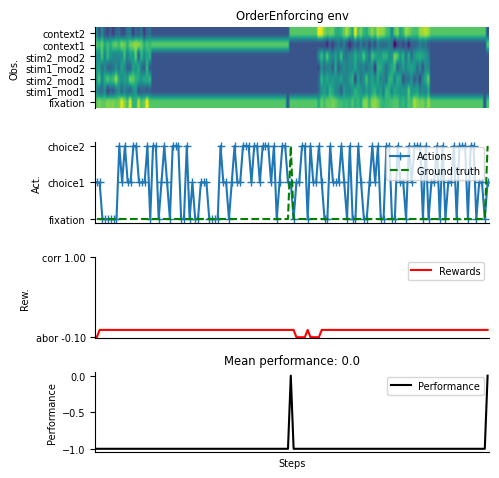

In [7]:
# @title Import the task from the neurogym library and make supervised dataset

import neurogym as ngym

import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Environment
task = 'ContextDecisionMaking-v0'
timing = {
    'fixation': ('choice', (50, 100, 200, 400)),
    'stimulus': ('choice', (100, 200, 400, 800)),
}
kwargs = {'dt': 20, 'timing': timing}
seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env
# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=2)

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

In [8]:
# @title Training Models
# Instantiate the networks and print information
hidden_size = 128

net_leaky = RNNNet(input_size=input_size, hidden_size=hidden_size,
            output_size=output_size, dt=env.dt)

net_sparse = RNNNet_sparse(input_size=input_size, hidden_size=hidden_size,
             output_size=output_size, sparsity=0.5, dt=env.dt)

net_EI = RNNNet_EI(input_size=input_size, hidden_size=hidden_size,
            output_size=output_size, dt=env.dt)

net_noise = RNNNet_noise(input_size=input_size, hidden_size=hidden_size,
            output_size=output_size, dt=env.dt)

def train_model(net, dataset, num_steps=2000):
    """Simple helper function to train the model.

    Args:
        net: a pytorch nn.Module module
        dataset: a dataset object that when called produce a (input, target output) pair

    Returns:
        net: network object after training
    """
    # Use Adam optimizer
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    running_loss = 0
    running_acc = 0
    start_time = time.time()

    loss_values = []
    # Loop over training batches
    print('Training network...')
    for i in range(num_steps):
        # Generate input and target, convert to pytorch tensor
        inputs, labels = dataset()
        inputs = torch.from_numpy(inputs).type(torch.float)
        labels = torch.from_numpy(labels.flatten()).type(torch.long)

        # boiler plate pytorch training:
        optimizer.zero_grad()   # zero the gradient buffers
        output, _ = net(inputs)
        # Reshape to (SeqLen x Batch, OutputSize)
        output = output.view(-1, output_size)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()    # Does the update

        # Compute the running loss every 100 steps
        running_loss += loss.item()
        if i % 100 == 99:
            running_loss /= 100
            print('Step {}, Loss {:0.4f}, Time {:0.1f}s'.format(
                i+1, running_loss, time.time() - start_time))
            loss_values.append(running_loss)
            running_loss = 0

    return net, loss_values

# Dictionary to store networks and their corresponding loss values
trained_networks = {}
loss_dict = {}

# Train each network and save the loss values

trained_networks['Leaky'], loss_dict['Leaky'] = train_model(net_leaky, dataset)
trained_networks['Sparse'], loss_dict['Sparse'] = train_model(net_sparse, dataset)
trained_networks['EI'], loss_dict['EI'] = train_model(net_EI, dataset)
trained_networks['Noise'], loss_dict['Noise'] = train_model(net_noise, dataset)

Training network...
Step 100, Loss 0.2106, Time 3.8s
Step 200, Loss 0.0766, Time 7.6s
Step 300, Loss 0.0553, Time 12.1s
Step 400, Loss 0.0500, Time 15.8s
Step 500, Loss 0.0483, Time 19.5s
Step 600, Loss 0.0479, Time 24.1s
Step 700, Loss 0.0455, Time 27.8s
Step 800, Loss 0.0451, Time 31.6s
Step 900, Loss 0.0459, Time 38.4s
Step 1000, Loss 0.0451, Time 43.1s
Step 1100, Loss 0.0453, Time 46.8s
Step 1200, Loss 0.0444, Time 51.6s
Step 1300, Loss 0.0447, Time 55.3s
Step 1400, Loss 0.0452, Time 59.0s
Step 1500, Loss 0.0441, Time 63.8s
Step 1600, Loss 0.0449, Time 67.5s
Step 1700, Loss 0.0438, Time 71.3s
Step 1800, Loss 0.0440, Time 75.7s
Step 1900, Loss 0.0430, Time 79.6s
Step 2000, Loss 0.0437, Time 83.4s
Training network...
Step 100, Loss 0.2015, Time 5.1s
Step 200, Loss 0.0712, Time 9.7s
Step 300, Loss 0.0536, Time 14.1s
Step 400, Loss 0.0500, Time 19.3s
Step 500, Loss 0.0475, Time 23.7s
Step 600, Loss 0.0468, Time 28.1s
Step 700, Loss 0.0460, Time 33.4s
Step 800, Loss 0.0468, Time 37.8s
S

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


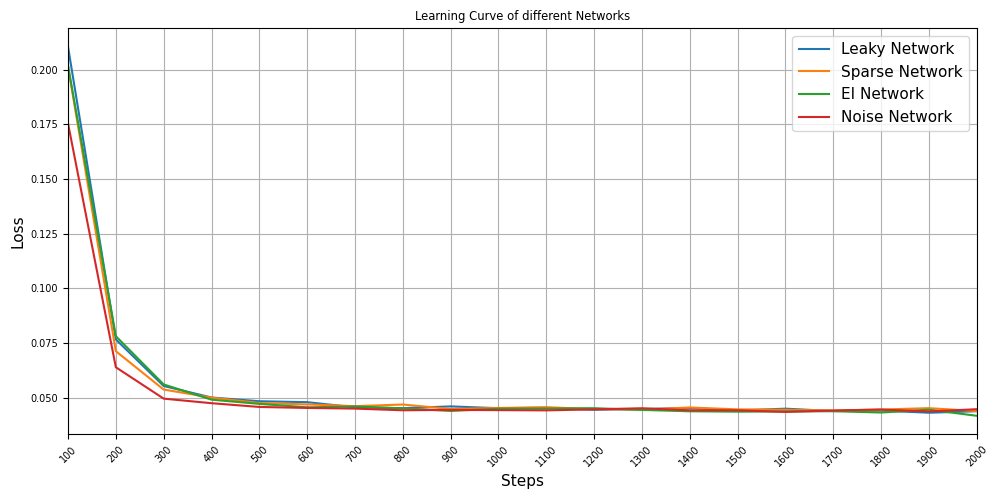

In [11]:
# @title Plotting the learning
# Set the default font to a safer option (like DejaVu Sans)
plt.rcParams['font.family'] = 'DejaVu Sans'

# Plotting the learning curve
plt.figure(figsize=(10,5))
for name, loss_values in loss_dict.items():
  steps = np.arange(100, 100 * (len(loss_values) + 1), 100)
  plt.plot(steps, loss_values, label=f'{name} Network')
plt.title("Learning Curve of different Networks")
plt.xlabel("Steps", fontsize = 11)
plt.ylabel("Loss", fontsize = 11)
plt.legend(fontsize = 11)
plt.grid(True)

plt.xticks(steps, rotation=45)
plt.xlim(steps[0], steps[-1])
plt.tight_layout()

plt.show()

In [22]:
# @title Testing models
def test_network(network, env, num_trials=500):
    """Test a given network and record activity, trial info, and stimulus selectivity.

    Args:
        network: a trained PyTorch RNN network.
        env: the environment object.
        num_trial: number of trials to test.

    Returns:
        activity_dict: dictionary of neural activity for each trial.
        trial_infos: dictionary of trial information.
        avg_perf: average performance of the network.
        stim_activity: list of neural activity during the stimulus for ground truth 0 and 1.
    """
    # Reset environment and adjust timing for stimulus and fixation periods
    env.reset(no_step=True)
    env.timing.update({'fixation': ('constant', 500), 'stimulus': ('constant', 500)})

    # Initialize variables for logging
    activity_dict = {}
    trial_infos = {}
    stim_activity = [[], []]
    correct_trials = 0

    for i in range(num_trials):
        # Generate a new trial
        env.new_trial()
        ob, gt = env.ob, env.gt

        # Prepare inputs for the network
        inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
        action_pred, rnn_activity = network(inputs)

        # Compute performance
        action_pred = action_pred.detach().numpy()
        choice = np.argmax(action_pred[-1, 0, :])
        correct = choice == gt[-1]
        if correct:
            correct_trials += 1

        # Log trial info
        trial_info = env.trial
        trial_info.update({'correct': correct, 'choice': choice})
        trial_infos[i] = trial_info

        # Record neural activity for the entire trial
        rnn_activity = rnn_activity[:, 0, :].detach().numpy()
        activity_dict[i] = rnn_activity

        # Extract activity during the stimulus period for selectivity analysis
        stim_activity_slice = rnn_activity[env.start_ind['stimulus']: env.end_ind['stimulus']]
        stim_activity[env.trial['context']].append(stim_activity_slice)

    # Calculate average performance
    avg_perf = correct_trials / num_trials

    return activity_dict, trial_infos, avg_perf, stim_activity

networks = {
    'Leaky': net_leaky,
    'Sparse': net_sparse,
    'EI': net_EI,
    'Noise': net_noise
}

# Running tests on all networks
results = {}
for name, network in networks.items():
    print(f"Testing {name} network...")
    activity_dict, trial_infos, avg_perf, stim_activity = test_network(network, dataset.env)

    results[name] = {
        'activity_dict': activity_dict,
        'trial_infos': trial_infos,
        'avg_performance': avg_perf,
        'stim_activity': stim_activity
    }

    print(f"{name} network average performance: {avg_perf:.2f}")

Testing Leaky network...
Leaky network average performance: 0.47
Testing Sparse network...
Sparse network average performance: 0.55
Testing EI network...
EI network average performance: 0.76
Testing Noise network...
Noise network average performance: 0.50


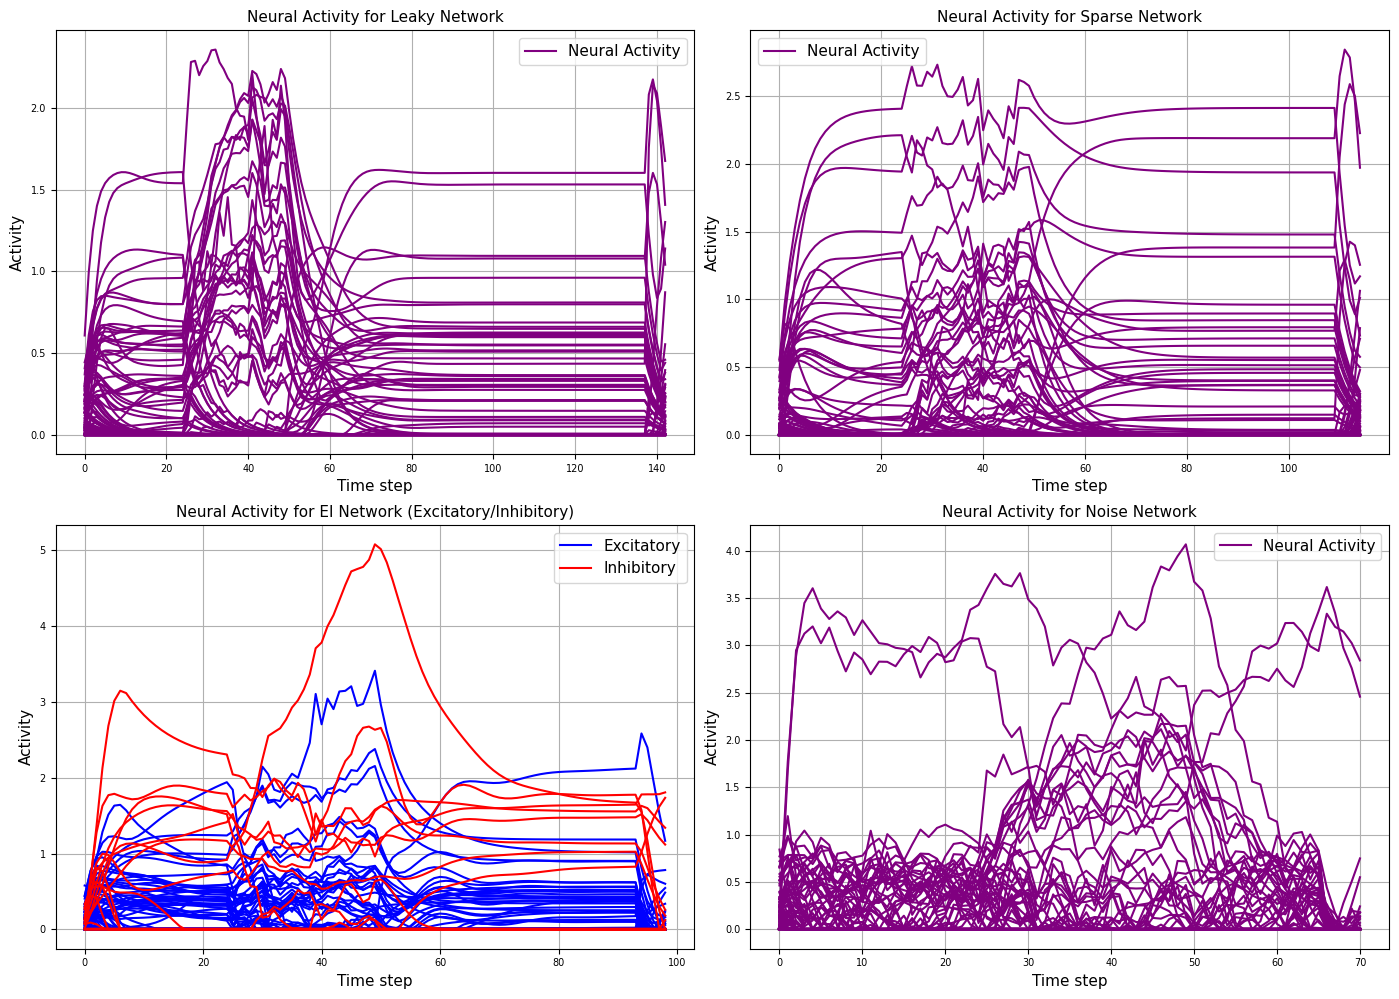

In [36]:
# @title Plot neural activity from sample trials for all networks
import logging
import matplotlib.pyplot as plt

# Suppress font warnings
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Set the trial number to visualize
trial = 20  # Change this to visualize a different trial

# Create a figure with subplots for each network
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Loop through each network and plot its neural activity
for idx, (name, data) in enumerate(results.items()):
    activity_dict = data['activity_dict']
    ax = axes[idx]

    # Check if the network is RNN_EI to plot excitatory and inhibitory separately
    if name == 'EI':
        e_size = networks[name].rnn.e_size
        ax.plot(activity_dict[trial][:, :e_size], color='blue')  # Excitatory
        ax.plot(activity_dict[trial][:, e_size:], color='red')   # Inhibitory

        # Add a single legend entry for excitatory and inhibitory lines
        ax.plot([], [], color='blue', label='Excitatory')
        ax.plot([], [], color='red', label='Inhibitory')
        ax.set_title(f"Neural Activity for {name} Network (Excitatory/Inhibitory)", fontsize=11)
        ax.legend(fontsize=11)
    else:
        # For other networks, just plot the entire activity
        ax.plot(activity_dict[trial], color='purple')
        ax.set_title(f"Neural Activity for {name} Network", fontsize=11)
        ax.legend(['Neural Activity'], fontsize=11)

    ax.set_xlabel('Time step', fontsize=11)
    ax.set_ylabel('Activity', fontsize=11)
    ax.grid(True)

plt.tight_layout()
plt.show()

Performing PCA analysis on Leaky network...
Shape of the neural activity (Time points, Neurons) for Leaky: (48727, 128)
Explained variance ratio (PC1 & PC2) for Leaky: [0.78046    0.07846076]


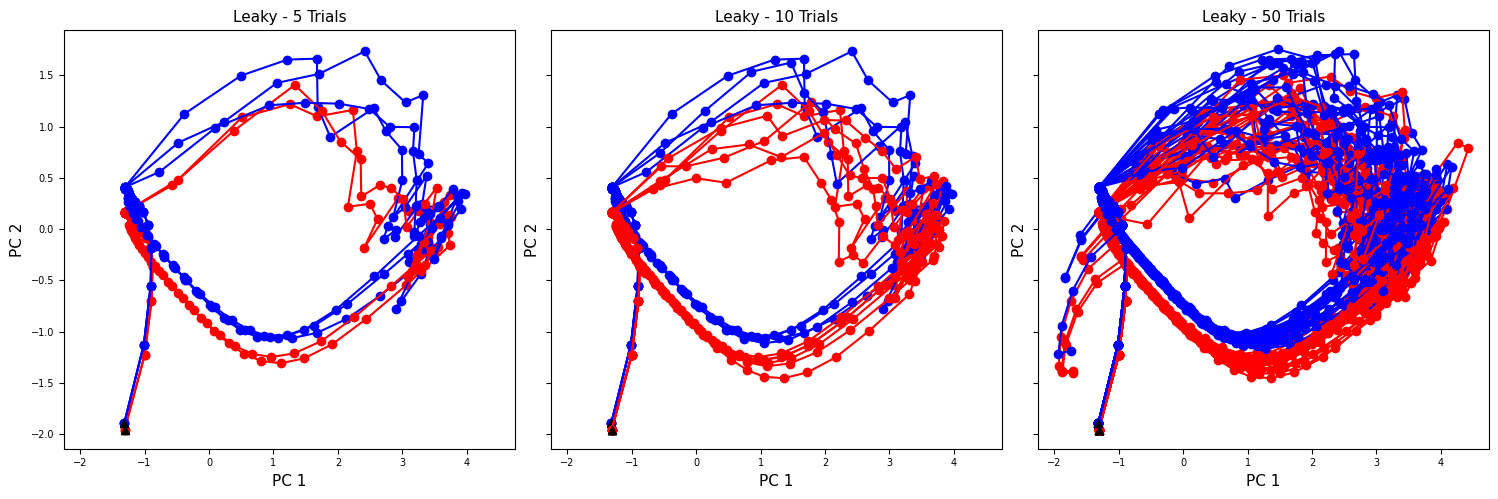

Performing PCA analysis on Sparse network...
Shape of the neural activity (Time points, Neurons) for Sparse: (49557, 128)
Explained variance ratio (PC1 & PC2) for Sparse: [0.6142701  0.17736055]


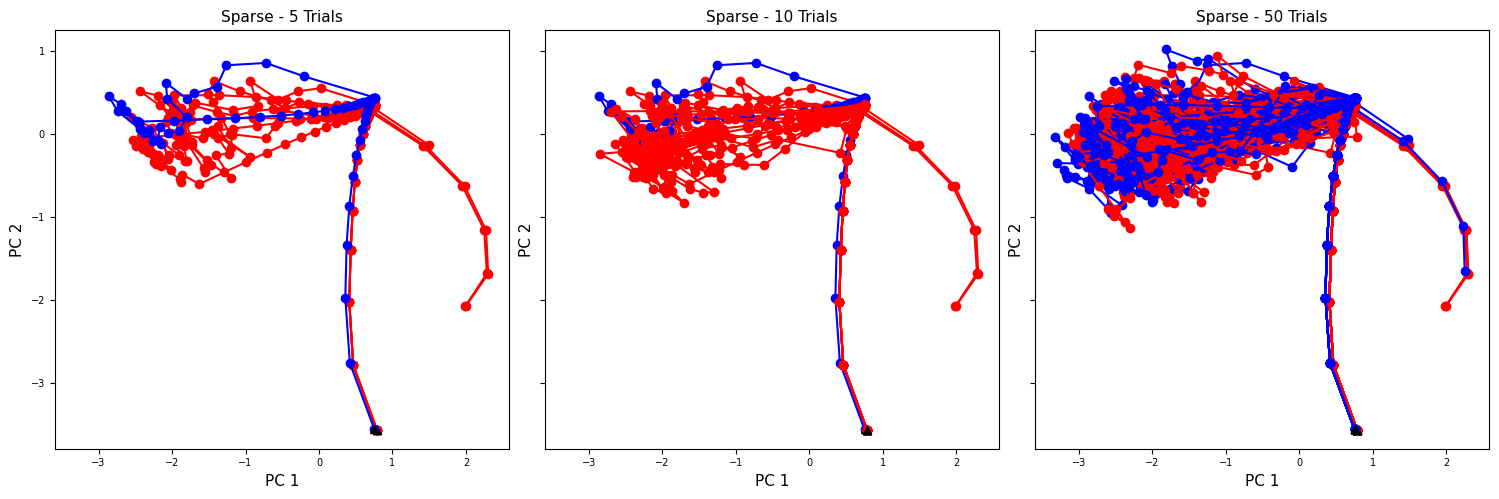

Performing PCA analysis on EI network...
Shape of the neural activity (Time points, Neurons) for EI: (48770, 128)
Explained variance ratio (PC1 & PC2) for EI: [0.7475042 0.1317271]


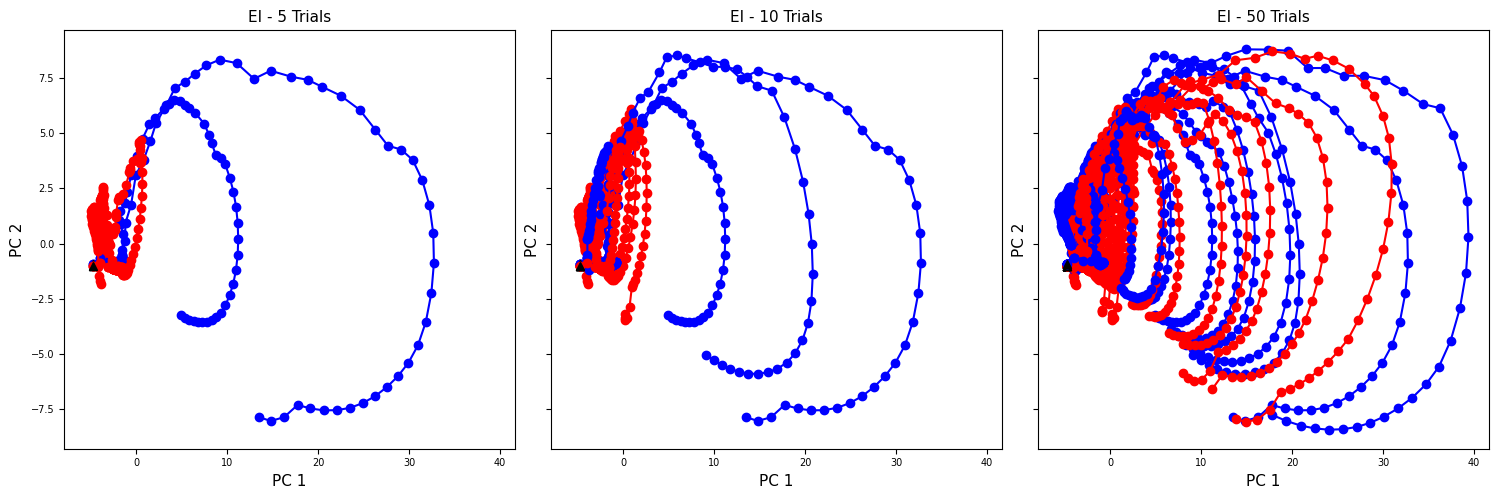

Performing PCA analysis on Noise network...
Shape of the neural activity (Time points, Neurons) for Noise: (48915, 128)
Explained variance ratio (PC1 & PC2) for Noise: [0.7177315  0.05587947]


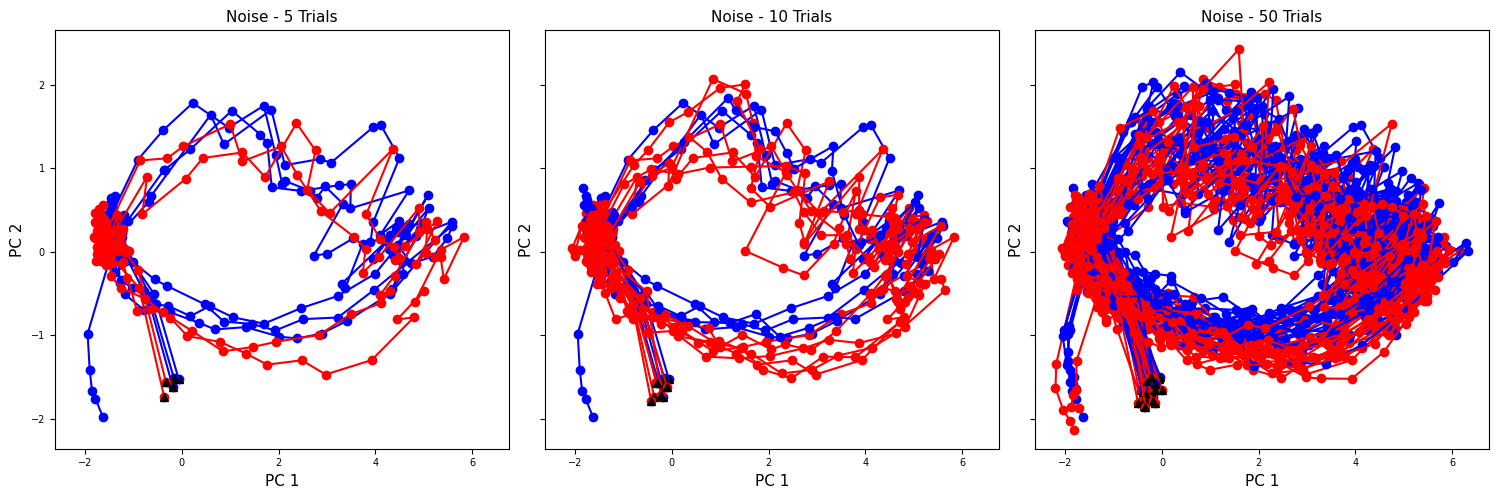

In [24]:
# @title PCA analysis
from sklearn.decomposition import PCA
import logging

logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

def perform_pca_analysis(network_name, activity_dict, trial_infos, num_trial=500, plot_until_time=70):
    """
    Performs PCA on the neural activity data and plots the results.

    Args:
        network_name (str): Name of the network (e.g., 'Leaky', 'Sparse', 'EI', 'Noise').
        activity_dict (dict): Dictionary containing neural activity for each trial.
        trial_infos (dict): Dictionary containing trial information.
        num_trial (int): Number of trials to include in the analysis.
        plot_until_time (int): Number of time steps to plot for each trial.
    """
    print(f"Performing PCA analysis on {network_name} network...")

    # Concatenate activity data across all trials for PCA
    activity = np.concatenate([activity_dict[i] for i in range(num_trial)], axis=0)
    print(f'Shape of the neural activity (Time points, Neurons) for {network_name}: {activity.shape}')

    # Initialize PCA and fit on the activity data
    pca = PCA(n_components=2)
    pca.fit(activity)
    print(f'Explained variance ratio (PC1 & PC2) for {network_name}: {pca.explained_variance_ratio_}')

    # Visualization
    fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 5))

    # Plot for the first 5 trials, 10 trials, and 50 trials
    for j, num_trials in enumerate([5, 10, 50]):
        ax = axs[j]
        for i in range(num_trials):
            # Transform and plot each trial's activity
            activity_pc = pca.transform(activity_dict[i])

            # Determine the color based on ground truth
            trial = trial_infos[i]
            color = 'red' if trial['context'] == 0 else 'blue'

            ax.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)

            # Indicate trial start with a different marker
            ax.plot(activity_pc[0, 0], activity_pc[0, 1], '^', color='black')

        # Set labels and titles for clarity
        ax.set_title(f'{network_name} - {num_trials} Trials', fontsize=11)
        ax.set_xlabel('PC 1', fontsize=11)
        ax.set_ylabel('PC 2', fontsize=11)

    plt.tight_layout()
    plt.show()

# Performing PCA on all networks
for name, network in networks.items():
    activity_dict = results[name]['activity_dict']
    trial_infos = results[name]['trial_infos']
    perform_pca_analysis(name, activity_dict, trial_infos)

ERROR: Could not find a version that satisfies the requirement fixed-point-finder-master (from versions: none)
ERROR: No matching distribution found for fixed-point-finder-master

Searching for fixed points from 10 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Maximum iteration count reached. Terminating.
		5000 iters
		q = 1.95e-07 +/- 3.56e-07
		dq = 2.24e-10 +/- 4.21e-10
		learning rate = 1.49e-02
		avg iter time = 2.69e-03 sec
	Identified 6 unique fixed points.
		initial_states: 0 outliers detected (of 10).
		fixed points: 0 outliers detected (of 6).
	Computing recurrent Jacobian at 6 unique fixed points.
	Computing input Jacobian at 6 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.



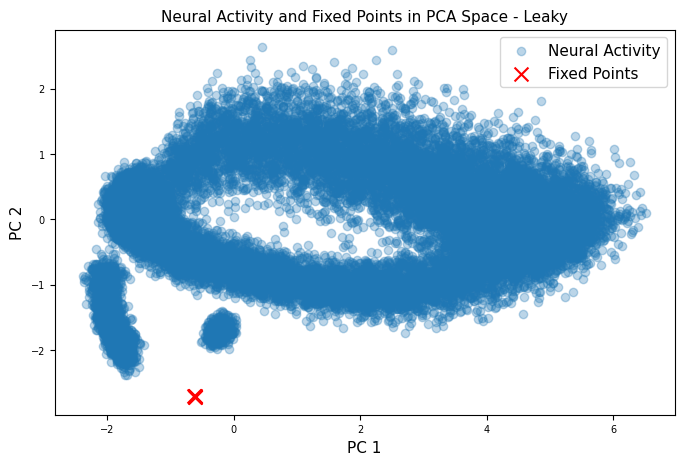

<Figure size 640x480 with 0 Axes>

In [26]:
# @title Fixed Point analysis - Leaky RNN

!pip install fixed-point-finder-master

import sys
sys.path.append('/content/fixed-point-finder-master')

# Import the FixedPointFinderTorch class
from FixedPointFinderTorch import FixedPointFinderTorch as FixedPointFinder
import torch

class FixedPointRNNWrapper(torch.nn.Module):
    def __init__(self, rnn, batch_first=False):
        super(FixedPointRNNWrapper, self).__init__()
        self.rnn = rnn
        self.batch_first = batch_first  # Ensure this matches your RNN's setting

    def forward(self, input, hidden):
        # Squeeze the extra dimension from hidden state
        # Hidden shape transforms from [1, batch_size, hidden_size] to [batch_size, hidden_size]
        hidden = hidden.squeeze(0)

        # EI-RNN expects inputs of shape [seq_len, batch_size, input_size]
        # Since we have seq_len=1, input shape is already correct

        # Forward pass through your EI-RNN
        output, hidden = self.rnn(input, hidden)

        # Unsqueeze hidden to match FixedPointFinder's expectation
        # Hidden shape transforms from [batch_size, hidden_size] to [1, batch_size, hidden_size]
        hidden = hidden.unsqueeze(0)

        # Return None for output as per FixedPointFinder's requirement
        return None, hidden

# Instantiate the FixedPointRNNWrapper with the EI-RNN model from Net
rnn_model_fixed_point = FixedPointRNNWrapper(net_leaky.rnn, batch_first=False)

# Instantiate FixedPointFinder with the wrapped EI-RNN model
finder = FixedPointFinder(rnn_model_fixed_point)

# Define initial conditions and inputs for fixed-point analysis
initial_conditions = torch.randn(10, net_leaky.rnn.hidden_size)  # 10 random initial hidden states
inputs = torch.zeros(10, net_leaky.rnn.input_size)  # Zero input for each initial condition

# Convert initial conditions and inputs to NumPy arrays for FixedPointFinder
init_hidden_np = initial_conditions.cpu().numpy()
inputs_np = inputs.cpu().numpy()

# Run fixed-point finding using the wrapped model
fixed_points_result = finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)

# Unpack the returned tuple
fps = fixed_points_result[0]  # Assuming FixedPoints object is the first element

# Access fixed points
fixed_points = fps.xstar  # Now you can access the xstar attribute

# Collect activity from all trials
activity_list = []
for trial_activity in activity_dict.values():
    activity_list.append(trial_activity)  # Each trial_activity is of shape [time_steps, hidden_size]
activity = np.vstack(activity_list)  # Concatenate along the time axis to get [total_time_steps, hidden_size]

# Convert fixed points list to numpy array if it's not already
fixed_points_array = np.vstack(fixed_points)  # Shape: [num_fixed_points, hidden_size]

# Apply PCA to project fixed points and neural activity into the same space
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
# Concatenate activity and fixed points for PCA projection
activity_and_fp = np.concatenate([activity, fixed_points_array], axis=0)
pca.fit(activity_and_fp)

# Transform activity and fixed points
activity_pc = pca.transform(activity)
fixed_points_pc = pca.transform(fixed_points_array)

# Plot activity and fixed points
plt.figure(figsize=(8, 5))
plt.scatter(activity_pc[:, 0], activity_pc[:, 1], alpha=0.3, label='Neural Activity')
plt.scatter(fixed_points_pc[:, 0], fixed_points_pc[:, 1], color='red', marker='x', s=100, label='Fixed Points')
plt.xlabel("PC 1", fontsize = 11)
plt.ylabel("PC 2", fontsize = 11)
plt.title("Neural Activity and Fixed Points in PCA Space - Leaky", fontsize = 11)
plt.legend(fontsize = 11)
plt.show()


Searching for fixed points from 10 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Optimization complete to desired tolerance.
		1234 iters
		q = 1.36e-13 +/- 2.81e-13
		dq = 3.00e-14 +/- 2.85e-14
		learning rate = 1.42e-01
		avg iter time = 1.06e-03 sec
	Identified 1 unique fixed points.
		initial_states: 0 outliers detected (of 10).
		fixed points: 0 outliers detected (of 1).
	Computing recurrent Jacobian at 1 unique fixed points.
	Computing input Jacobian at 1 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.



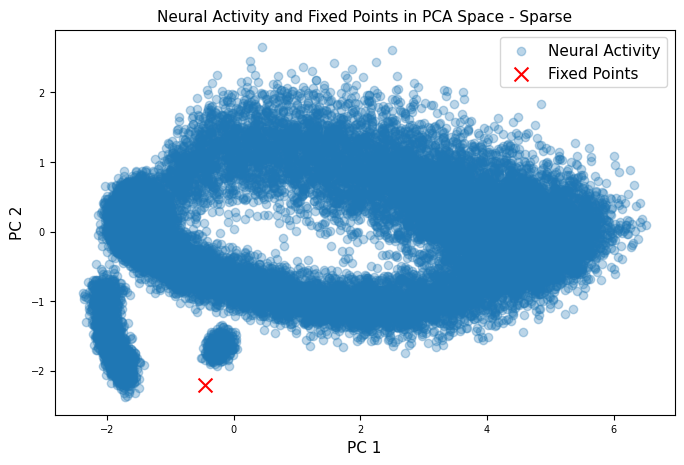

<Figure size 640x480 with 0 Axes>

In [27]:
# @title Fixed Point analysis - Sparse Leaky RNN
# Instantiate the FixedPointRNNWrapper with the EI-RNN model from Net
rnn_model_fixed_point = FixedPointRNNWrapper(net_sparse.rnn, batch_first=False)

# Instantiate FixedPointFinder with the wrapped EI-RNN model
finder = FixedPointFinder(rnn_model_fixed_point)

# Define initial conditions and inputs for fixed-point analysis
initial_conditions = torch.randn(10, net_sparse.rnn.hidden_size)  # 10 random initial hidden states
inputs = torch.zeros(10, net_sparse.rnn.input_size)  # Zero input for each initial condition

# Convert initial conditions and inputs to NumPy arrays for FixedPointFinder
init_hidden_np = initial_conditions.cpu().numpy()
inputs_np = inputs.cpu().numpy()

# Run fixed-point finding using the wrapped model
fixed_points_result = finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)

# Unpack the returned tuple
fps = fixed_points_result[0]  # Assuming FixedPoints object is the first element

# Access fixed points
fixed_points = fps.xstar  # Now you can access the xstar attribute

# Collect activity from all trials
activity_list = []
for trial_activity in activity_dict.values():
    activity_list.append(trial_activity)  # Each trial_activity is of shape [time_steps, hidden_size]
activity = np.vstack(activity_list)  # Concatenate along the time axis to get [total_time_steps, hidden_size]

# Convert fixed points list to numpy array if it's not already
fixed_points_array = np.vstack(fixed_points)  # Shape: [num_fixed_points, hidden_size]

# Apply PCA to project fixed points and neural activity into the same space
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
# Concatenate activity and fixed points for PCA projection
activity_and_fp = np.concatenate([activity, fixed_points_array], axis=0)
pca.fit(activity_and_fp)

# Transform activity and fixed points
activity_pc = pca.transform(activity)
fixed_points_pc = pca.transform(fixed_points_array)

# Plot activity and fixed points
plt.figure(figsize=(8, 5))
plt.scatter(activity_pc[:, 0], activity_pc[:, 1], alpha=0.3, label='Neural Activity')
plt.scatter(fixed_points_pc[:, 0], fixed_points_pc[:, 1], color='red', marker='x', s=100, label='Fixed Points')
plt.xlabel("PC 1", fontsize = 11)
plt.ylabel("PC 2", fontsize = 11)
plt.title("Neural Activity and Fixed Points in PCA Space - Sparse", fontsize = 11)
plt.legend(fontsize = 11)
plt.show()


Searching for fixed points from 10 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Maximum iteration count reached. Terminating.
		5000 iters
		q = 1.11e-05 +/- 7.80e-06
		dq = 2.74e-08 +/- 4.58e-08
		learning rate = 4.38e-02
		avg iter time = 1.19e-03 sec
	Identified 10 unique fixed points.
		initial_states: 0 outliers detected (of 10).
		fixed points: 0 outliers detected (of 10).
	Computing recurrent Jacobian at 10 unique fixed points.
	Computing input Jacobian at 10 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.



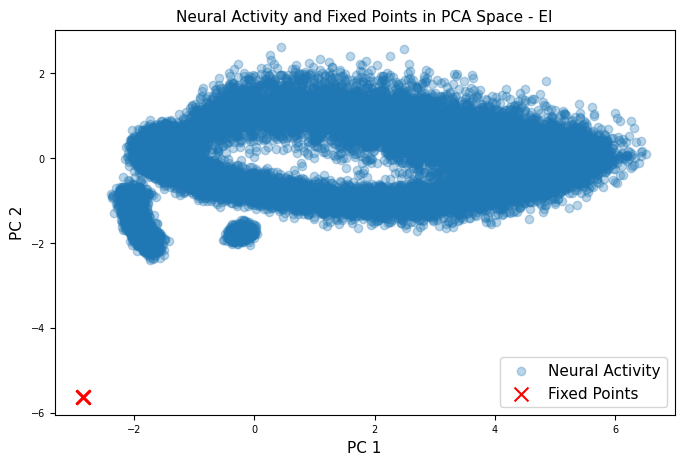

<Figure size 640x480 with 0 Axes>

In [28]:
# @title Fixed Point analysis - EI Leaky RNN
class FixedPointRNNWrapper_EI(torch.nn.Module):
    def __init__(self, rnn, batch_first=False):
        super(FixedPointRNNWrapper_EI, self).__init__()
        self.rnn = rnn
        self.batch_first = batch_first  # Ensure this matches your RNN's setting

    def forward(self, input, hidden):
        # Squeeze the extra dimension from hidden state
        # Hidden shape transforms from [1, batch_size, hidden_size] to [batch_size, hidden_size]
        hidden = hidden.squeeze(0)

        # EI-RNN expects inputs of shape [seq_len, batch_size, input_size]
        # Since we have seq_len=1, input shape is already correct

        # Forward pass through your EI-RNN
        output, hidden = self.rnn(input, (hidden, hidden))

        # Unsqueeze hidden to match FixedPointFinder's expectation
        # Hidden shape transforms from [batch_size, hidden_size] to [1, batch_size, hidden_size]
        hidden = hidden[0].unsqueeze(0)

        # Return None for output as per FixedPointFinder's requirement
        return None, hidden

# Instantiate the FixedPointRNNWrapper with the EI-RNN model from Net
rnn_model_fixed_point = FixedPointRNNWrapper_EI(net_EI.rnn, batch_first=False)

# Instantiate FixedPointFinder with the wrapped EI-RNN model
finder = FixedPointFinder(rnn_model_fixed_point)

# Define initial conditions and inputs for fixed-point analysis
initial_conditions = torch.randn(10, net_EI.rnn.hidden_size)  # 10 random initial hidden states
inputs = torch.zeros(10, net_EI.rnn.input_size)  # Zero input for each initial condition

# Convert initial conditions and inputs to NumPy arrays for FixedPointFinder
init_hidden_np = initial_conditions.cpu().numpy()
inputs_np = inputs.cpu().numpy()

# Run fixed-point finding using the wrapped model
fixed_points_result = finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)

# Unpack the returned tuple
fps = fixed_points_result[0]  # Assuming FixedPoints object is the first element

# Access fixed points
fixed_points = fps.xstar  # Now you can access the xstar attribute

# Collect activity from all trials
activity_list = []
for trial_activity in activity_dict.values():
    activity_list.append(trial_activity)  # Each trial_activity is of shape [time_steps, hidden_size]
activity = np.vstack(activity_list)  # Concatenate along the time axis to get [total_time_steps, hidden_size]

# Convert fixed points list to numpy array if it's not already
fixed_points_array = np.vstack(fixed_points)  # Shape: [num_fixed_points, hidden_size]

# Apply PCA to project fixed points and neural activity into the same space
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
# Concatenate activity and fixed points for PCA projection
activity_and_fp = np.concatenate([activity, fixed_points_array], axis=0)
pca.fit(activity_and_fp)

# Transform activity and fixed points
activity_pc = pca.transform(activity)
fixed_points_pc = pca.transform(fixed_points_array)

# Plot activity and fixed points
plt.figure(figsize=(8, 5))
plt.scatter(activity_pc[:, 0], activity_pc[:, 1], alpha=0.3, label='Neural Activity')
plt.scatter(fixed_points_pc[:, 0], fixed_points_pc[:, 1], color='red', marker='x', s=100, label='Fixed Points')
plt.xlabel("PC 1", fontsize = 11)
plt.ylabel("PC 2", fontsize = 11)
plt.title("Neural Activity and Fixed Points in PCA Space - EI", fontsize = 11)
plt.legend(fontsize = 11)
plt.show()


Searching for fixed points from 10 initial states.

	Freezing model parameters so model is not affected by fixed point optimization.
	Finding fixed points via joint optimization.
	Maximum iteration count reached. Terminating.
		5000 iters
		q = 1.12e+00 +/- 1.42e-01
		dq = 1.83e-01 +/- 1.42e-01
		learning rate = 1.97e-07
		avg iter time = 1.08e-03 sec
	Identified 10 unique fixed points.
		initial_states: 0 outliers detected (of 10).
		fixed points: 0 outliers detected (of 10).
	Computing recurrent Jacobian at 10 unique fixed points.
	Computing input Jacobian at 10 unique fixed points.
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.
	Fixed point finding complete.



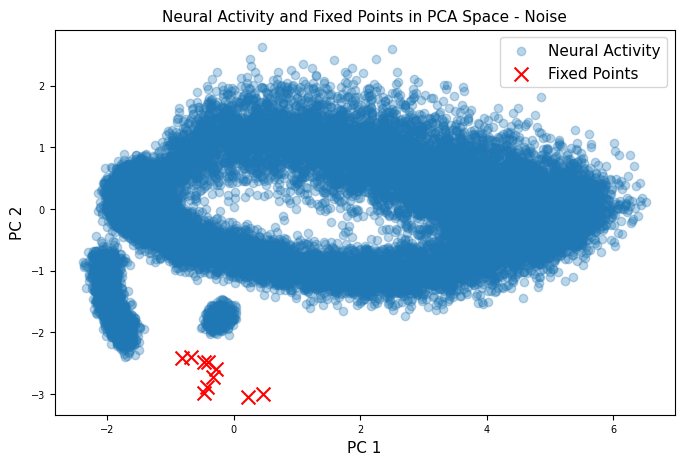

In [32]:
# @title Fixed Point analysis - Noise Leaky RNN
# Instantiate the FixedPointRNNWrapper with the EI-RNN model from Net
rnn_model_fixed_point = FixedPointRNNWrapper_EI(net_noise.rnn, batch_first=False)

# Instantiate FixedPointFinder with the wrapped EI-RNN model
finder = FixedPointFinder(rnn_model_fixed_point)

# Define initial conditions and inputs for fixed-point analysis
initial_conditions = torch.randn(10, net_noise.rnn.hidden_size)  # 10 random initial hidden states
inputs = torch.zeros(10, net_noise.rnn.input_size)  # Zero input for each initial condition

# Convert initial conditions and inputs to NumPy arrays for FixedPointFinder
init_hidden_np = initial_conditions.cpu().numpy()
inputs_np = inputs.cpu().numpy()

# Run fixed-point finding using the wrapped model
fixed_points_result = finder.find_fixed_points(initial_states=init_hidden_np, inputs=inputs_np)

# Unpack the returned tuple
fps = fixed_points_result[0]  # Assuming FixedPoints object is the first element

# Access fixed points
fixed_points = fps.xstar  # Now you can access the xstar attribute

# Collect activity from all trials
activity_list = []
for trial_activity in activity_dict.values():
    activity_list.append(trial_activity)  # Each trial_activity is of shape [time_steps, hidden_size]
activity = np.vstack(activity_list)  # Concatenate along the time axis to get [total_time_steps, hidden_size]

# Convert fixed points list to numpy array if it's not already
fixed_points_array = np.vstack(fixed_points)  # Shape: [num_fixed_points, hidden_size]

# Apply PCA to project fixed points and neural activity into the same space
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
# Concatenate activity and fixed points for PCA projection
activity_and_fp = np.concatenate([activity, fixed_points_array], axis=0)
pca.fit(activity_and_fp)

# Transform activity and fixed points
activity_pc = pca.transform(activity)
fixed_points_pc = pca.transform(fixed_points_array)

# Plot activity and fixed points
plt.figure(figsize=(8, 5))
plt.scatter(activity_pc[:, 0], activity_pc[:, 1], alpha=0.3, label='Neural Activity')
plt.scatter(fixed_points_pc[:, 0], fixed_points_pc[:, 1], color='red', marker='x', s=100, label='Fixed Points')
plt.xlabel("PC 1", fontsize = 11)
plt.ylabel("PC 2", fontsize = 11)
plt.title("Neural Activity and Fixed Points in PCA Space - Noise", fontsize = 11)
plt.legend(fontsize = 11)
plt.show()